In [97]:
import numpy as np 
import matplotlib.pyplot as pl

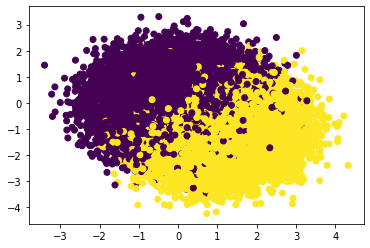

In [98]:
# Generate data from 2D Gaussians
y = np.random.binomial(1,0.5,100000)
x = np.c_[np.random.normal(y,0.8),np.random.normal(-y,0.8)]

pl.scatter(x[:,0],x[:,1],c=y)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into training and testing (70/30 split); shuffle order, just in case
# Fix random seed for reproducibility
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)

# Perform input variable transformations - StandardScaler sets mean of each feature to 0, std to 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled) # Use same scaling transformation on test and train data (do not pick a new mean, std)
x_all = scaler.transform(x) 

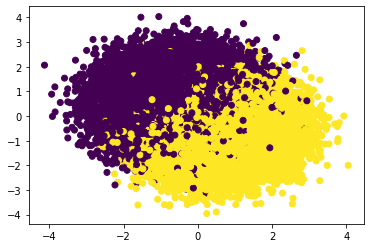

In [100]:
# plot transformed data

pl.scatter(x_all[:,0],x_all[:,1],c=y)

## Let's train a BDT

In [101]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# Make the base classifier (single decision tree) - not yet trained, includes termination condition
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=10)
# Now combine a bunch of decision trees; number set by n_estimators. 
# The specific way samples are re-weighted is controlled by the AdaBoost algorithm
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=50,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(x_train, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

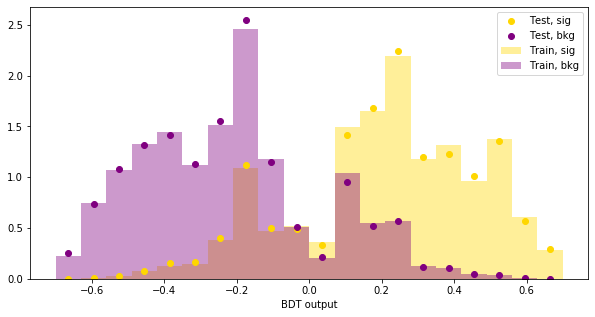

In [102]:
# Evaluate the BDT on the test (and train) data
y_pred_test = model.decision_function(x_test)
y_pred_sig_train = model.decision_function(x_train[y_train==1])
y_pred_sig_test = model.decision_function(x_test[y_test==1])
y_pred_bkg_train = model.decision_function(x_train[y_train==0])
y_pred_bkg_test = model.decision_function(x_test[y_test==0])

n_bins=20
hist_range=(-0.7,0.7)
sig_color = 'gold'
bkg_color = 'purple'
pl.figure(figsize=(10,5))
pl.hist(y_pred_sig_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=sig_color,label="Train, sig")
counts,bin_edges = np.histogram(y_pred_sig_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
pl.plot(bin_centers, counts,marker="o",linestyle="None",color=sig_color,label="Test, sig")

pl.hist(y_pred_bkg_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=bkg_color,label="Train, bkg")
counts,bin_edges = np.histogram(y_pred_bkg_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
pl.plot(bin_centers, counts,marker="o",linestyle="None",color=bkg_color,label="Test, bkg")

pl.legend()
pl.xlabel('BDT output')
pl.show()

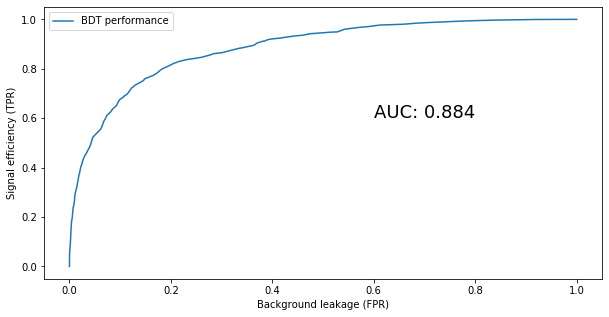

In [103]:
# sklearn is great for convenience functions like calculating the ROC curve!

# Use the test data, since the training data can "cheat" by overfitting
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1
# calculate AUC
auc_score = auc(BDT_FPR_test, BDT_TPR_test)

pl.figure(figsize=(10,5))
pl.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
pl.text(0.6, 0.6, 'AUC: {0:.3f}'.format(auc_score), fontsize=18)
pl.xlabel('Background leakage (FPR)')
pl.ylabel('Signal efficiency (TPR)')
pl.legend()
pl.show()

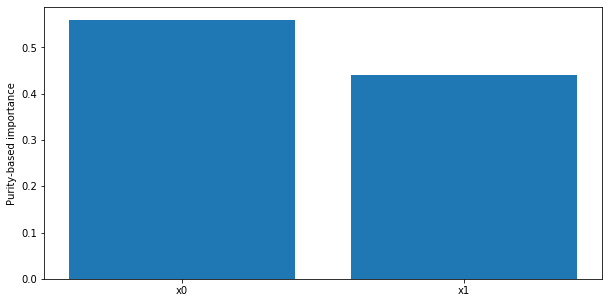

In [104]:
# Get feature ranking based on change in impurity from branching on given features
variable_names = ['x0','x1'] # <-- replace w/ meaningful names for your case; easy to keep track of w/ e.g. a pandas dataframe
importances = np.array(list(zip(variable_names, model.feature_importances_)))
# Sort in order of importance (then reverse so most important is first)
importances = importances[importances[:, 1].argsort()]
importances = importances[::-1]

# Plot variable importances
pl.figure(figsize=(10,5))
pl.bar(importances[:,0],importances[:,1].astype(float),bottom=0)
pl.ylabel("Purity-based importance")
pl.show()

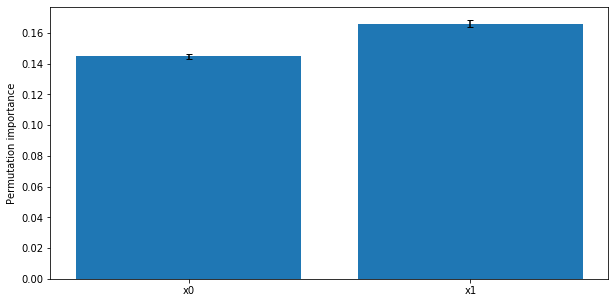

In [105]:
from sklearn.inspection import permutation_importance

# shuffle inputs one-by-one and see how much worse performance is
# note that this doesn't work out of the box with weighted data (but can be fixed by copying the open-source implementation and adding a couple lines)
r = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=0)
    
# Plot variable importances
pl.figure(figsize=(10,5))
pl.bar(variable_names, r.importances_mean, yerr=r.importances_std, bottom=0, capsize=3)
pl.ylabel("Permutation importance")
pl.show()

## k-fold cross validation and hyperparameter optimization

In [106]:
from sklearn.model_selection import cross_val_score, GridSearchCV

DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=10)
BDT = AdaBoostClassifier(base_estimator=DTC,algorithm = 'SAMME')

# Annoying caveat: sklearn's cross-validation doesn't deal w/ weighted data properly
clf = GridSearchCV(estimator=BDT, param_grid={'n_estimators': [1, 7, 50, 100]}, cv=5) # you can also change things like the metric used to evaluate models
clf.fit(x_all, y) # now we can use ALL THE DATA =D

# The simpler version with just cross-validation:
#scores = cross_val_score(BDT, x_all, y, cv=5)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                                min_samples_split=10)),
             param_grid={'n_estimators': [1, 7, 50, 100]})

In [70]:
# Print out a basic report of the results
print("Keys available from CV results: \n",sorted(clf.cv_results_.keys()))
score_means = clf.cv_results_['mean_test_score']
score_stds = clf.cv_results_['std_test_score']
param = next(iter(clf.param_grid))
for ii in range(len(score_means)):
    print("Parameter {0}={1}, accuracy: {2:0.3f} (+/- {3:0.4f})".format(param, clf.param_grid[param][ii], score_means[ii], score_stds[ii]))

Keys available from CV results: 
 ['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_n_estimators', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
Parameter n_estimators=1, accuracy: 0.773 (+/- 0.0040)
Parameter n_estimators=7, accuracy: 0.796 (+/- 0.0018)
Parameter n_estimators=50, accuracy: 0.806 (+/- 0.0014)
Parameter n_estimators=100, accuracy: 0.807 (+/- 0.0013)


## Unsupervised learning: Gaussian mixture model

In [45]:
from sklearn.mixture import GaussianMixture

# Define the 2D array of data to cluster
gm = GaussianMixture(n_components=2, random_state=0, n_init=1).fit(x_train)
cluster_output = gm.predict(x_test)
# Scores are most relevant when comparing multiple models on the same problem, i.e. values are relative
gm_score = gm.score(x_test) 
gm_aic = gm.aic(x_test)
gm_bic = gm.bic(x_test)
print("Score: {0}, AIC: {1}, BIC: {2}".format(gm_score, gm_aic, gm_bic))

Score: -2.7854749487135853, AIC: 167150.4969228151, BIC: 167241.89540208218


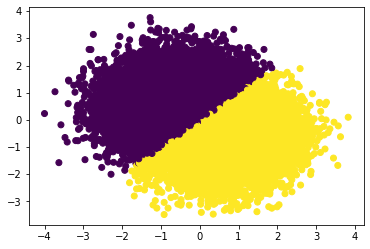

In [46]:
pl.scatter(x_test[:,0],x_test[:,1],c=cluster_output)